In [1]:
import rebound
import reboundx
import sys
sys.path.append('../systemsounds')
import systemsounds as ss
import numpy as np
from random import random, uniform, seed
from systemsounds import EventRecorder
import scipy as sp
from math import *
import pandas as pd

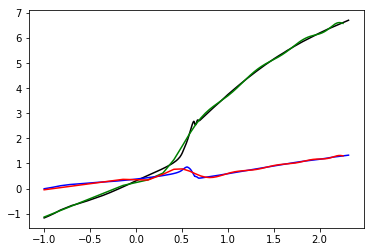

In [47]:
# Stellar tracks fits: L(M) and R(M)

# Read the stellar tracks file with pandas. This is the only file needed
tracksdf = pd.read_table('./startrackextended.txt', header=0,delimiter=r"\s+")


# Fit log_L then log_R as a function of log(mass) using polynomials
FitLfuncM = np.polyfit(np.log10(tracksdf['star_mass']), tracksdf['log_L'], 16)
FitRfuncM = np.polyfit(np.log10(tracksdf['star_mass']), tracksdf['log_R'], 20)


# Convenience function to easily call the polynomials as functions 
# These are the functions you will need to use
# example: Luminosity for a 1 solar mass star: PolyLfuncM(np.log10(1.))
# It hence takes logs and output logs
PolyLfuncM = np.poly1d(FitLfuncM)
PolyRfuncM = np.poly1d(FitRfuncM)



############################## PLOT ############################
# stellar mass array
arraytest = np.linspace(0.1,180.,len(tracksdf['log_L']))

# Compare fit and data for L func of M
plt.plot(np.log10(tracksdf['star_mass']),tracksdf['log_L'], color='black')
plt.plot(np.log10(arraytest),PolyLfuncM(np.log10(arraytest).reshape((len(arraytest),1))), color='green')

# Compare fit and data for R func of M
plt.plot(np.log10(tracksdf['star_mass']),tracksdf['log_R'], color='blue')
plt.plot(np.log10(arraytest),PolyRfuncM(np.log10(arraytest).reshape((len(arraytest),1))), color='red')

plt.show()
############################## END sPLOT ############################



In [2]:
def acrit(sim): # Holman & Wiegert 99 for P type circumbinary
    ps = sim.particles
    mu = ps[1].m/(ps[1].m+ps[0].m)
    return 1.60 + 5.10*ps[1].e -2.22*ps[1].e**2 + 4.12*mu -4.27*ps[1].e*mu -5.09*mu**2 + 4.61*ps[1].e**2*mu**2 

def stop(reb_sim, reb_col):
    reb_sim.contents._status = 6
    return 0

def distance(sim, i1, i2):
    ps = sim.particles
    diff = ps[i2]-ps[i1]
    return np.sqrt(diff.x**2 + diff.y**2 + diff.z**2)

class mindRecorder(EventRecorder):
    def __init__(self, sim, starindex):
        self.starindex = starindex
        self.mind = 0.99*min(distance(sim, 0, 2), distance(sim, 1,2)) # needs to start less than initial value
        self.mind0 = self.mind
        super(mindRecorder, self).__init__(sim, lambda sim, i: self.mind-distance(sim, 2, self.starindex), targets=[None])
    def process_event(self, event_sim, target=None):
        self.mind = distance(event_sim, 2, self.starindex)
        super(mindRecorder, self).process_event(event_sim, target)

In [3]:
def runbinary(randseed=0, mratio=None, ebinary=None):
    seed(randseed)
    if mratio is None:
        mratio = random()
    if ebinary is None:
        ebinary = 0.9*random()
        
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    Rmin = 1.e-2
    sim.add(m=1., r=Rmin)
    sim.add(m=mratio, a=1., e=ebinary, r=Rmin, pomega=random()*2.*np.pi, f=random()*2.*np.pi)
    sim.move_to_com()
    ps = sim.particles
    sim.add(a=1.2*acrit(sim), f=random()*2.*np.pi)
    
    sim.exit_max_distance= 100.
    sim.collision="direct"
    sim.collision_resolve = stop

    rebx = reboundx.Extras(sim)
    rebx.add("modify_orbits_forces")
    ps[2].params['tau_a'] = -1000*ps[2].P
    
    recorder1 = mindRecorder(sim, 0)
    recorder2 = mindRecorder(sim, 1)
    tmax=1.e4
    
    code=0
    try:
        sim.integrate(tmax)
    except KeyboardInterrupt:
        code=1
    except rebound.Escape:
        code=2
    
    return recorder1.mind, recorder2.mind, recorder1.mind0, mratio, ebinary, code

In [ ]:
results = []

In [18]:
%%time
for i in range(50):
    results.append(runbinary(i))

CPU times: user 21min 32s, sys: 7.44 s, total: 21min 40s
Wall time: 21min 56s


In [22]:
len(results)

100

In [23]:
a = np.array(results)

In [45]:
a.T[1]/a.T[2] >= 1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [24]:
a.T[-1]

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [27]:
a.T[0]

array([ 1.78329977,  1.52557641,  1.87137137,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.78329977,  1.52557641,  1.87137137,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.5571218 ,  1.73793254,  1.58650227,  1.7635907 ,  2.45637413,
        0.86173634,  1.67033211,  1.76815646,  2.15946278,  1.65666711,
        1.98389217,  1.80264726,  1.19839629,  1.53667233,  1.71625098,
        1.78736884,  1.57184552,  1.37976748,  0.95539387,  1.54733047,
        2.0864506 ,  1.02912888,  1.65990233,  1.90729919,  1.90540263,
        1.61849337,  1.88943365,  1.33621662,  1.5688969 ,  2.2054188 ,
        1.78329977,  1.52557641,  2.88160079,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.5571218 ,  1.73793254,  1.58650227,  1.7635907 ,  2.45637413,
        0.86173634,  1.67033211,  1.76815646,  2.15946278,  1.65

In [32]:
a.T[1]

array([ 2.17861947,  1.12755222,  1.34604282,  1.43641985,  0.94392675,
        2.37178323,  1.74481514,  0.75306337,  0.96521088,  1.76644693,
        2.17861947,  1.12755222,  1.34604282,  1.43641985,  0.94392675,
        2.37178323,  1.74481514,  0.75306337,  0.96521088,  1.76644693,
        1.69885469,  1.52919249,  1.56072743,  1.56703334,  1.11293799,
        1.20627323,  1.5997457 ,  1.3811392 ,  1.48006539,  2.3660353 ,
        1.9536595 ,  1.70452908,  1.25062143,  2.38322869,  2.50359668,
        1.37251911,  1.35826948,  2.03073767,  0.70864407,  1.52266633,
        1.54349562,  0.17733924,  0.79880511,  2.06235103,  1.5153764 ,
        1.94602356,  1.93353632,  1.18948774,  1.26748676,  1.22215989,
        2.17861947,  1.12755222,  2.89054866,  1.43641985,  0.94392675,
        2.37178323,  1.74481514,  0.75306337,  0.96521088,  1.76644693,
        1.69885469,  1.52919249,  1.56072743,  1.56703334,  1.11293799,
        1.20627323,  1.5997457 ,  1.3811392 ,  1.48006539,  2.36

ValueError: too many values to unpack (expected 2)

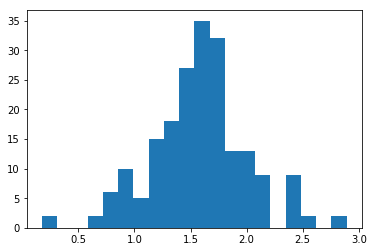

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.hist(np.concatenate((a.T[0], a.T[1])), bins=20)

In [54]:
def get_a_binary(M_primary):
    return 1.

def get_a_Roche(Mstar):
    rho_sun = 1.4
    rho_body = 3
    Rsun = 5e-3
    return 1.26*Mstar**(1./3.)*(rho_sun/rho_body)**(1./3.)*Rsun

def get_Rstar(Mstar):
    Rsun = 5.e-3
    return 10**PolyRfuncM(np.log10(Mstar))*Rsun

get_a_binary = np.vectorize(get_a_binary)
get_a_Roche = np.vectorize(get_a_Roche)
get_Rstar = np.vectorize(get_Rstar)

In [85]:
typemasses = {'VLM':[1.e-3, 0.1], 'M':[0.1, 0.6], 'FGK':[0.6, 1.4], 'A':[1.4, 6.5], 'OB':[6.5, 100]}

def get_type(M):
    for key, value in typemasses.items():
        if M > value[0] and M < value[1]:
            return key
    return np.nan

def sample_mass(startype):
    Mmin, Mmax = typemasses[startype]
    return Mmin + (Mmax-Mmin)*random()

In [88]:
get_type(35)

'OB'

In [ ]:
if M <= 0.1:
   s_type = ('VLM')
   a_avg = 4.5#average separation (au)
   a_sigma = 0.333
elif M > 0.1 and M <= 0.6:
   s_type = ('Mstar')
   a_avg = 5.3#average separation (au)
   a_sigma = 0.867
elif M > 0.6 and M <= 1.4:
   s_type = ('FKG')
   a_avg = 45#average separation (au)
   a_sigma = 1.533
elif M > 1.4 and M <= 6.5:
   s_type = ('A stars')
   bimodal = 1
   a_avg = 350
   a_avg2 = 0.2
   a_sigma = 1.533
   a_sigma2 = 1
elif M > 6.5 and M <= 16:
   s_type = ('EarlyB')
   powerlaw = 1
   a_avg = 0.2
   a_sigma = 1.533
elif M > 16:
   s_type = ('Ostar')
   powerlaw = 1
   a_avg = 0.2
   a_sigma = 0.1677

In [60]:
def sample(randseed=0):
    seed(randseed)
    Mmin = 0.1
    Mmax = 0.5
    M = Mmin + (Mmax-Mmin)*random()
    a_bin = get_a_binary(M)
    a_Roche1 = get_a_Roche(M)
    a_Roche2 = get_a_Roche(M*q)
    Rstar1 = get_Rstar(M)
    Rstar2 = get_Rstar(M*q)

    row = a[np.random.randint(0, a.shape[0])]
    dmin1 = row[0]
    dmin2 = row[1]
    q = row[3]

    dmin1Roche = dmin1*a_bin/a_Roche1
    dmin2Roche = dmin2*a_bin/a_Roche2
    dmin1R = dmin1*a_bin/Rstar1
    dmin2R = dmin2*a_bin/Rstar2

0.39349795593439396

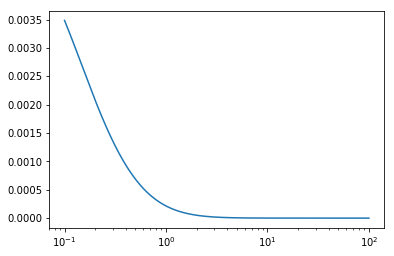

In [210]:
def IMFChab(M):
    IMFChab = 0.086*(1./(np.log(10)*M))*np.exp(-((np.log10(M)-np.log10(0.22))**(2.))/(2.*0.57**2.))/89.450710273055023
    return IMFChab

starmasses = np.linspace(0.1,100,100000)
IMF = IMFChab(starmasses)
plt.plot(starmasses, IMF)
plt.xscale('log')
plt.show()

In [211]:
IMF.sum()

1.0000000000000004

In [212]:
IMF[0]+IMF[1]

0.0069532433007887112

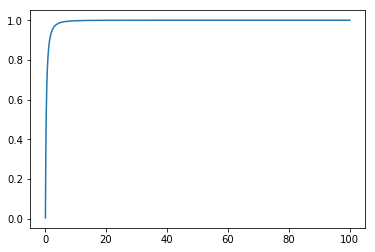

In [213]:
IMFcdf = np.cumsum(IMF)
plt.plot(starmasses, IMFcdf)
plt.xscale('log')
plt.show()

In [214]:
IMFcdf[1]

0.0069532433007887112

In [239]:
from scipy.interpolate import interp1d
f = interp1d(IMFcdf, starmasses)

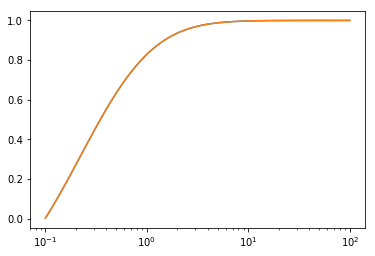

In [222]:
plt.plot(starmasses, IMFcdf)
plt.plot(starmasses, f(starmasses))
plt.xscale('log')
plt.show()

In [230]:
IMFcdf

array([ 0.00348604,  0.00695324,  0.01040169, ...,  1.        ,
        1.        ,  1.        ])

In [209]:
sample_from_IMF(2)

0.9560342718892494 0.2404


2.5016200162001621

In [205]:
starmasses[977]

1.0760327603276034

In [246]:
def find_nearest(array,value):
    return np.abs(array-value).argmin()

def sample_from_IMF(randseed=0):
    seed(randseed)
    val = random()
    idx = find_nearest(IMFcdf, val)
    #print(val, idx/10000)
    return starmasses[idx]

In [247]:
b = [np.log10(sample_from_IMF(i)) for i in range(10000)]

(array([  2.50200000e+03,   2.47000000e+03,   2.18300000e+03,
          1.46300000e+03,   8.41000000e+02,   3.58000000e+02,
          1.26000000e+02,   4.50000000e+01,   1.10000000e+01,
          1.00000000e+00]),
 array([-1.        , -0.73487539, -0.46975078, -0.20462618,  0.06049843,
         0.32562304,  0.59074765,  0.85587226,  1.12099686,  1.38612147,
         1.65124608]),
 <a list of 10 Patch objects>)

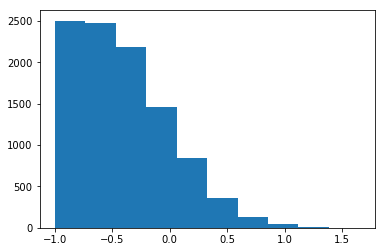

In [248]:
plt.hist(b)

In [227]:
np.random.random([2])

array([ 0.4170149 ,  0.58703222])

In [235]:
np.random.random([100]).max()

0.99370252715694896

(array([ 84.,  92.,  86.,  73.,  54.,  48.,  34.,  14.,   8.,   7.]),
 array([-0.99986934, -0.81384086, -0.62781238, -0.44178391, -0.25575543,
        -0.06972695,  0.11630153,  0.30233001,  0.48835849,  0.67438697,
         0.86041545]),
 <a list of 10 Patch objects>)

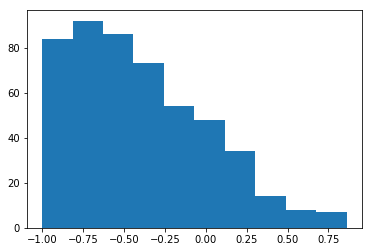

In [243]:
plt.hist(np.log10(f(np.random.random([500]))))

In [231]:
plt.hist(f(np.random.random([100])))

ValueError: A value in x_new is below the interpolation range.

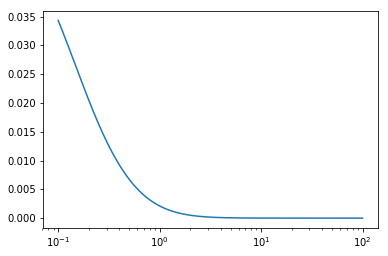

In [155]:
def IMFChab(M):
    IMFChab = 0.086*(1./(np.log(10)*M))*np.exp(-((np.log10(M)-np.log10(0.22))**(2.))/(2.*0.57**2.))/9.0859844454274068
    return IMFChab

starmasses = np.linspace(0.1,100.,10000)
plt.plot(arraytest, IMFChab(starmasses))
plt.xscale('log')
plt.show()

In [113]:
find_nearest(mIMFcdf, 0.5)

118

In [114]:
starmasses[118]

1.2789378937893792

In [109]:
mIMFcdf[119]

0.5025035315571611

In [102]:
IMFChab(arraytest).sum()

0.99999999999999978

In [75]:
a[np.random.randint(0, 100)]

array([ 2.45637413,  1.11293799,  4.78878971,  0.10682854,  0.63232697,  2.        ])

In [61]:
a.T[0]

array([ 1.78329977,  1.52557641,  1.87137137,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.78329977,  1.52557641,  1.87137137,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.5571218 ,  1.73793254,  1.58650227,  1.7635907 ,  2.45637413,
        0.86173634,  1.67033211,  1.76815646,  2.15946278,  1.65666711,
        1.98389217,  1.80264726,  1.19839629,  1.53667233,  1.71625098,
        1.78736884,  1.57184552,  1.37976748,  0.95539387,  1.54733047,
        2.0864506 ,  1.02912888,  1.65990233,  1.90729919,  1.90540263,
        1.61849337,  1.88943365,  1.33621662,  1.5688969 ,  2.2054188 ,
        1.78329977,  1.52557641,  2.88160079,  1.61715802,  1.51593435,
        1.55447933,  2.0318769 ,  1.49197215,  1.47389207,  1.86556759,
        1.5571218 ,  1.73793254,  1.58650227,  1.7635907 ,  2.45637413,
        0.86173634,  1.67033211,  1.76815646,  2.15946278,  1.65

In [52]:
get_a_binary(a.T[0])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [21]:
%%time
runbinary(randseed=2)

CPU times: user 1min 7s, sys: 73.7 ms, total: 1min 7s
Wall time: 1min 7s


(2.3188690829069274,
 1.6683421439663941,
 5.0379786134527178,
 0.9560342718892494,
 0.9478274870593494,
 2)

In [118]:
sim = rebound.Simulation()
sim.G = 4*np.pi**2
Rmin = 1./215.
sim.add(m=1., r=Rmin)
sim.add(m=1., a=1., e=0.1, r=Rmin)
sim.move_to_com()
ps = sim.particles

In [119]:
print('acrit = {0}'.format(acrit(sim)))
sim.add(a=1.2*acrit(sim))
print(ps[2].a)
sim.exit_max_distance= 100.
sim.collision="direct"
sim.collision_resolve = stop

rebx = reboundx.Extras(sim)
rebx.add("modify_orbits_forces")
ps[2].params['tau_a'] = -1000*ps[2].P

acrit = 2.6733249999999997
3.2079899999999997


In [3]:
recorder1 = mindRecorder(sim, 0)
recorder2 = mindRecorder(sim, 1)

NameError: name 'sim' is not defined

In [121]:
%%time
Nout = 1000
tmax = 10000
times = np.linspace(0, tmax, Nout)
d1, d2 = np.zeros(Nout), np.zeros(Nout)
P, e = np.zeros(Nout), np.zeros(Nout)

try:
    for i, time in enumerate(times):
        sim.integrate(time)
        d1[i] = distance(2, 0)
        d2[i] = distance(2, 1)
        P[i] = ps[2].P
        e[i] = ps[2].e
except KeyboardInterrupt:
    print("collision")
except rebound.Escape:
    print("escape")

escape
CPU times: user 5.37 s, sys: 24.9 ms, total: 5.39 s
Wall time: 5.42 s


In [122]:
recorder2.mind

1.2265316858253774

In [123]:
recorder1.mind

1.3890708302316288

In [19]:
sim.t

0.2696133632101861

(0, 3)

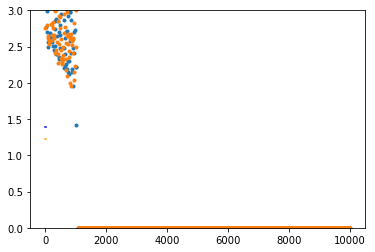

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax= plt.subplots()
ax.plot(times, d1, '.')
ax.plot([0,10], [recorder1.mind, recorder1.mind], 'blue')
ax.plot(times, d2, '.')
ax.plot([0,10], [recorder2.mind, recorder2.mind], 'orange')


#ax.set_xlim([0,10])
ax.set_ylim([0,3])

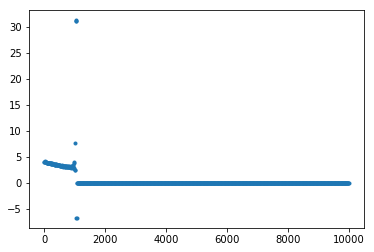

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax= plt.subplots()
ax.plot(times, P, '.')

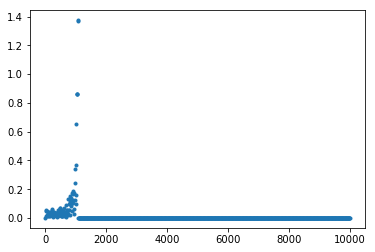

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax= plt.subplots()
ax.plot(times, e, '.')

In [5]:
runbinary(1)

3.2079899999999975
1053.657472316494 1.47545167801 1.19094200001


(1.4754516780140603, 1.1909420000054411)